### Using the Mauna Lua CO2 dataset (monthly) perform forecasting using an MLP and compare the results with that of MA (Moving Average) and ARMA (Auto Regressive Moving Average) models. Main setting: use previous “K” readings to predict next “T” reading. Example, if “K=3” and “T=1” then we use data from Jan, Feb, March and then predict the reading for April. Comment on why you observe such results. For MA or ARMA you can use any library or implement it from scratch. The choice of MLP is up to you. **[2 marks]**

Importing Libraries

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader



if (torch.cuda.is_available()):
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Supported Device: {device}")

Supported Device: cpu


Loading the data

Mauna Lua CO2 Dataset - https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_mm_mlo.csv

In [6]:
df = pd.read_csv('co2_mm_mlo.csv')
df

,year,month,decimal date,average,deseasonalized,ndays,sdev,unc
0,1958,3,1958.2027,315.70,314.43,-1,-9.99,-0.99
1,1958,4,1958.2877,317.45,315.16,-1,-9.99,-0.99
2,1958,5,1958.3699,317.51,314.71,-1,-9.99,-0.99
3,1958,6,1958.4548,317.24,315.14,-1,-9.99,-0.99
4,1958,7,1958.5370,315.86,315.18,-1,-9.99,-0.99
...,...,...,...,...,...,...,...,...
787,2023,10,2023.7917,418.82,422.12,27,0.47,0.17
788,2023,11,2023.8750,420.46,422.46,21,0.91,0.38
789,2023,12,2023.9583,421.86,422.58,20,0.68,0.29
790,2024,1,2024.0417,422.80,422.45,27,0.73,0.27


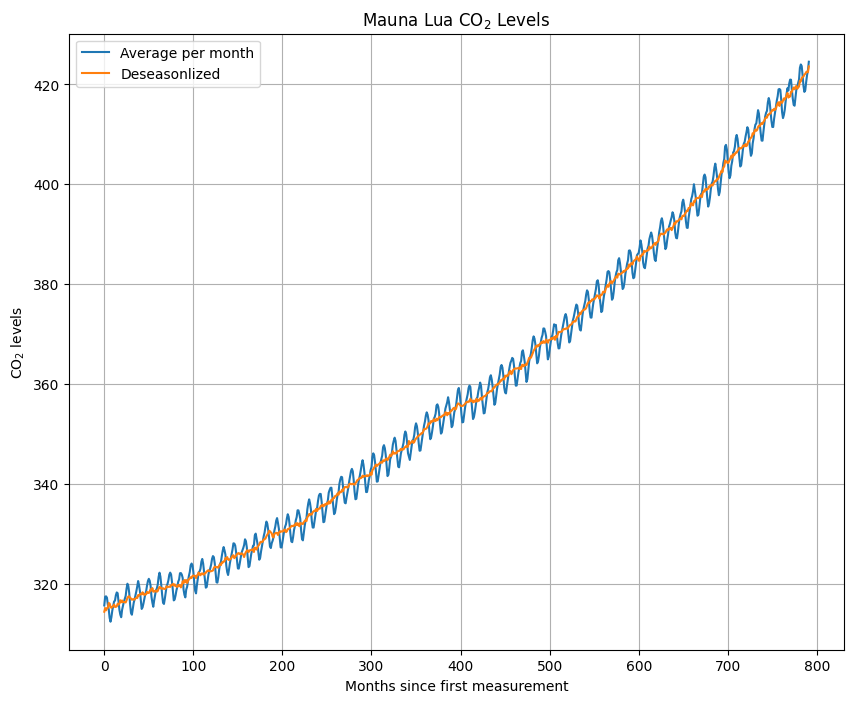

In [7]:
fig = plt.figure(figsize=(10,8))
plt.title(r'Mauna Lua CO$_2$ Levels')
plt.plot(df.index, df['average'])
plt.plot(df.index, df['deseasonalized'])
plt.xlabel('Months since first measurement')
plt.ylabel(r'CO$_2$ levels')
plt.grid()
plt.legend(['Average per month', 'Deseasonlized'])
plt.show()

Creating features

![Dataset](data.png)
<br>L = Number of Samples
<br>K = Feature Window Size
<br>T = Label Window Size

In [8]:
scaler = StandardScaler().fit(df['average'].values.reshape(-1,1))
scaled_D = scaler.transform(df['average'].values.reshape(-1,1))
scaled_D.shape, scaled_D

((792, 1),
 array([[-1.3721661 ],
        [-1.31653778],
        [-1.31463052],
        [-1.32321318],
        [-1.36708008],
        [-1.39664256],
        [-1.45163513],
        [-1.4761116 ],
        [-1.44750274],
        [-1.40490734],
        [-1.37598061],
        [-1.34737176],
        [-1.34196787],
        [-1.30795512],
        [-1.28983618],
        [-1.29428645],
        [-1.34546451],
        [-1.40077495],
        [-1.43129106],
        [-1.44750274],
        [-1.40045708],
        [-1.37598061],
        [-1.34896114],
        [-1.33147796],
        [-1.31240539],
        [-1.26631335],
        [-1.23420786],
        [-1.24851229],
        [-1.29333282],
        [-1.36580858],
        [-1.42080115],
        [-1.43160894],
        [-1.39441743],
        [-1.35659017],
        [-1.33433884],
        [-1.30859087],
        [-1.28188928],
        [-1.25200892],
        [-1.21704255],
        [-1.24279052],
        [-1.28093565],
        [-1.3375176 ],
        [-1.39473531],


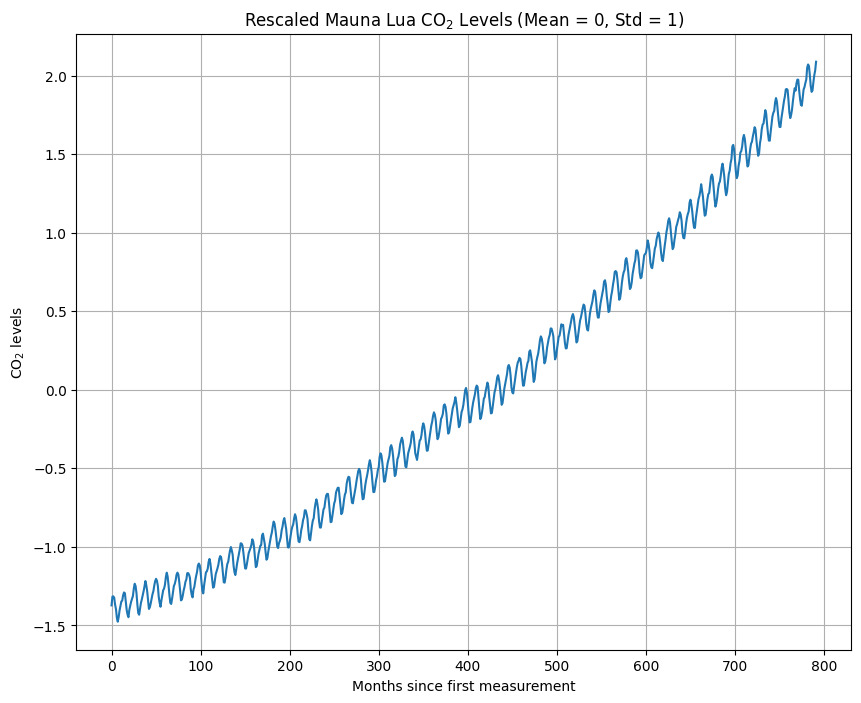

In [9]:
fig = plt.figure(figsize=(10,8))
plt.title(r'Rescaled Mauna Lua CO$_2$ Levels (Mean = 0, Std = 1)')
plt.plot(df.index, scaled_D)
plt.xlabel('Months since first measurement')
plt.ylabel(r'CO$_2$ levels')
plt.grid()
plt.show()

Generalized Code

In [125]:
class KTEstimator():
    def __init__(self, data:np.array = scaled_D, K = 3, T = 1, train_size:float = 0.80) -> None:
        self.K = K
        self.T = T
        self.istrained = False
        
        # Creating Feature - Label Matrix        
        D = np.zeros(shape=(len(data)-(self.K+self.T)+1, self.K+self.T))
        for i in range(D.shape[0]):
            D[i] = np.concatenate([data[i:i+self.K,0], data[i+self.K:i+self.K+self.T,0]])
        
        # Test Train Split
        X_train, X_test, y_train, y_test = D[:int(len(D)*train_size),:self.K], D[int(len(D)*train_size):,:self.K], D[:int(len(D)*train_size),self.K:self.K+self.T], D[int(len(D)*train_size):,self.K:self.K+self.T]
        X_train = torch.tensor(X_train,dtype = torch.float32, device = device, requires_grad=False)
        y_train = torch.tensor(y_train,dtype = torch.float32, device = device, requires_grad=False)
        X_test = torch.tensor(X_test,dtype = torch.float32, device = device, requires_grad=False)
        y_test = torch.tensor(y_test,dtype = torch.float32, device = device, requires_grad=False)

        self.X_train, self.X_test, self.y_train, self.y_test = X_train, X_test, y_train, y_test

        return None
    
    def fit(self, model, convergence:float = 1e-8, num_epochs:int = 2000, batch_size:int = 32, lr:float = 0.001):

        # Training the model
        loss_fn = nn.MSELoss()
        opt = torch.optim.Adam(model.parameters(), lr = lr)
        print_every = 100

        dataset = TensorDataset(self.X_train, self.y_train)
        train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        losses = []

        for epoch in range(num_epochs):
            l = 0
            for data, target in train_dataloader:
                opt.zero_grad()
                y_pred = model(data)
                loss = loss_fn(y_pred, target.reshape(-1,self.T))
                l += loss.item()
                loss.backward()
                opt.step()
            
            losses.append(l/len(self.X_train))

            if epoch != 0 and abs(losses[-1] - losses[-2]) < convergence:
                print(f'Final Training Loss: {losses[-1]}')
                print(f'Converged after {epoch} epochs')
                break

            if epoch % print_every == 0:
                print(f"Epoch: {epoch} | Loss: {losses[-1]}")
        
        self.train_loss = losses
        return None
    
    def predict(self, model, seed:int = 42, num_test_cases:int = 5, cumulative:bool = False, pred_len:int = 10):
        loss_fn = nn.MSELoss()
        np.random.seed(seed)

        if self.istrained == False:
            # Untrained Model Prediction
            if cumulative == False:
                with torch.no_grad():
                    test_indices = np.random.randint(0, len(self.X_test), size = num_test_cases)
                    for i in test_indices:
                        y = model(self.X_test[i])
                        loss = loss_fn(y, self.y_test[i])
                        plt.title(f'Extrapolation\nUntrained Model Prediction on Test Data\nTest Index: {i} | MSE: {loss}')
                        plt.plot(np.arange(i+len(self.X_train),i+len(self.X_train)+self.K,1), self.X_test[i], 'bo-')
                        plt.plot(np.arange(i+len(self.X_train)+self.K,i+len(self.X_train)+self.K+self.T,1), self.y_test[i].detach().numpy(), 'go-')
                        plt.plot(np.arange(i+len(self.X_train)+self.K,i+len(self.X_train)+self.K+self.T,1), y.detach().numpy(), 'ro-')
                        plt.legend(['Input','Ground Truth','Predicted'])
                        plt.xlabel('Months since first measurement')
                        plt.ylabel(r'Normalized CO$_2$ levels')
                        plt.grid()
                        plt.show()
            else:
                if self.K + pred_len > len(self.X_test):
                    print(f'Sum of input feature length: {self.K} and output predicted length {pred_len} greater test size: {len(self.X_test)}')
                else:
                    test_index = np.random.randint(0, len(self.X_test)-(self.K+pred_len))
                    y = torch.zeros(pred_len, dtype=torch.float16, device=device, requires_grad=False)
                    for i in range(pred_len):
                        if i:
                            y[i] = model(torch.concat((self.X_test[test_index+i, 0:self.K-i], y[0:i])))
                        else:
                            y[i] = model(self.X_test[test_index+i, 0:self.K])
                    loss = loss_fn(y.view(-1,1), self.y_test[test_index: test_index + pred_len])
                    plt.title(f'Cumulative Extrapolation\nUntrained Model Prediction on Test Data\nTest Index: {test_index} | MSE: {loss}')
                    plt.plot(np.arange(test_index+len(self.X_train),test_index+len(self.X_train)+self.K,1), self.X_test[test_index], 'bo-')
                    plt.plot(np.arange(test_index+len(self.X_train)+self.K,test_index+len(self.X_train)+self.K+pred_len,1), self.y_test[test_index:test_index + pred_len].detach().numpy(), 'go-')
                    plt.plot(np.arange(test_index+len(self.X_train)+self.K,test_index+len(self.X_train)+self.K+pred_len,1), y.detach().numpy(), 'ro-')
                    plt.legend(['Input','Ground Truth','Predicted'])
                    plt.xlabel('Months since first measurement')
                    plt.ylabel(r'Normalized CO$_2$ levels')
                    plt.grid()
                    plt.show()
        else:
            # Trained Model Prediction
            if cumulative == False:
                with torch.no_grad():
                    test_indices = np.random.randint(0, len(self.X_test), size = num_test_cases)
                    for i in test_indices:
                        y = model(self.X_test[i])
                        loss = loss_fn(y, self.y_test[i])
                        plt.title(f'Extrapolation\nTrained Model Prediction on Test Data\nTest Index: {i} | MSE: {loss}')
                        plt.plot(np.arange(i+len(self.X_train),i+len(self.X_train)+self.K,1), self.X_test[i], 'bo-')
                        plt.plot(np.arange(i+len(self.X_train)+self.K,i+len(self.X_train)+self.K+self.T,1), self.y_test[i].detach().numpy(), 'go-')
                        plt.plot(np.arange(i+len(self.X_train)+self.K,i+len(self.X_train)+self.K+self.T,1), y.detach().numpy(), 'ro-')
                        plt.legend(['Input','Ground Truth','Predicted'])
                        plt.xlabel('Months since first measurement')
                        plt.ylabel(r'Normalized CO$_2$ levels')
                        plt.grid()
                        plt.show()
            else:
                if self.K + pred_len > len(self.X_test):
                    print(f'Sum of input feature length: {self.K} and output predicted length {pred_len} greater test size: {len(self.X_test)}')
                else:
                    test_index = np.random.randint(0, len(self.X_test)-(self.K+pred_len))
                    y = torch.zeros(pred_len, dtype=torch.float16, device=device, requires_grad=False)
                    for i in range(pred_len):
                        if i:
                            y[i] = model(torch.concat((self.X_test[test_index+i, 0:self.K-i], y[0:i])))
                        else:
                            y[i] = model(self.X_test[test_index+i, 0:self.K])
                    loss = loss_fn(y.view(-1,1), self.y_test[test_index:test_index + pred_len])
                    plt.title(f'Cumulative Extrapolation\nTrained Model Prediction on Test Data\nTest Index: {test_index} | MSE: {loss}')
                    plt.plot(np.arange(test_index+len(self.X_train),test_index+len(self.X_train)+self.K,1), self.X_test[test_index], 'bo-')
                    plt.plot(np.arange(test_index+len(self.X_train)+self.K,test_index+len(self.X_train)+self.K+pred_len,1), self.y_test[test_index:test_index + pred_len].detach().numpy(), 'go-')
                    plt.plot(np.arange(test_index+len(self.X_train)+self.K,test_index+len(self.X_train)+self.K+pred_len,1), y.detach().numpy(), 'ro-')
                    plt.legend(['Input','Ground Truth','Predicted'])
                    plt.xlabel('Months since first measurement')
                    plt.ylabel(r'Normalized CO$_2$ levels')
                    plt.grid()
                    plt.show()
        return None

Multilayer Perceptron

In [105]:
class MLP(nn.Module):
  def __init__(self, input_dim, hidden_size1, hidden_size2, output_dim):
    super(MLP, self).__init__()
    self.lin1 = nn.Linear(input_dim, hidden_size1)
    self.lin2 = nn.Linear(hidden_size1, hidden_size2)
    self.lin3 = nn.Linear(hidden_size2, output_dim)

  def forward(self, x):
    y1 = self.lin1(x)
    y2 = torch.relu(y1)
    y3 = self.lin2(y2)
    y4 = torch.relu(y3)
    y = self.lin3(y4)
    return y

Extrapolation (Given K, predict the next T)

In [100]:
K = 30
T = 10

hidden_size1 = 15
hidden_size2 = 8

model = MLP(input_dim = K, hidden_size1 = hidden_size1 , hidden_size2 = hidden_size2, output_dim = T)

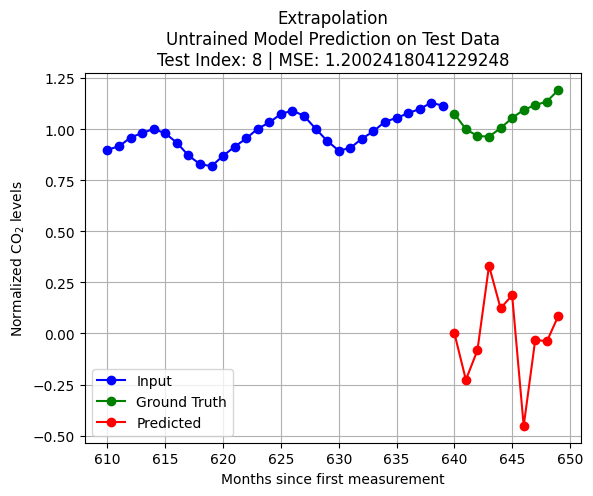

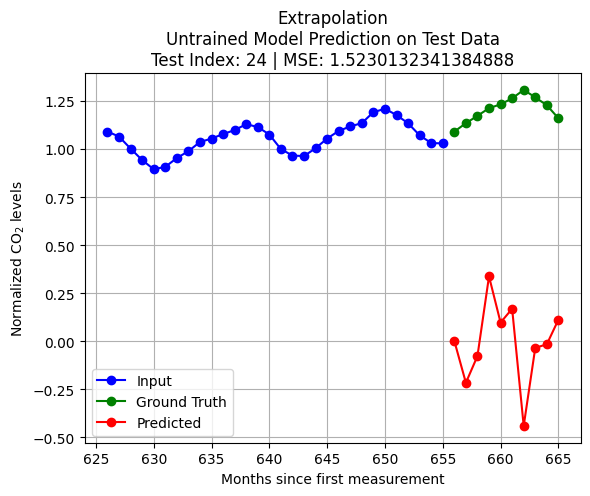

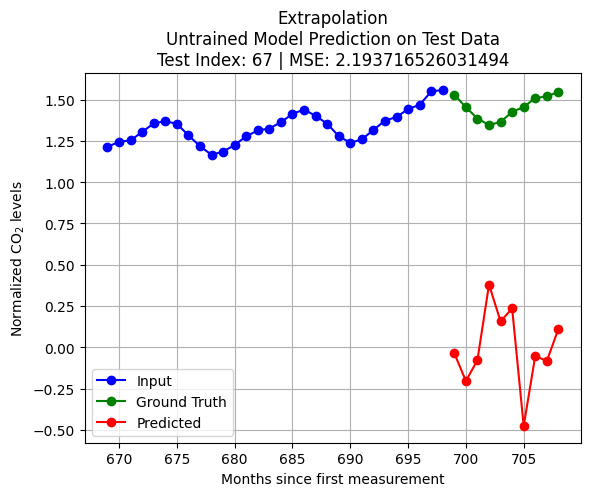

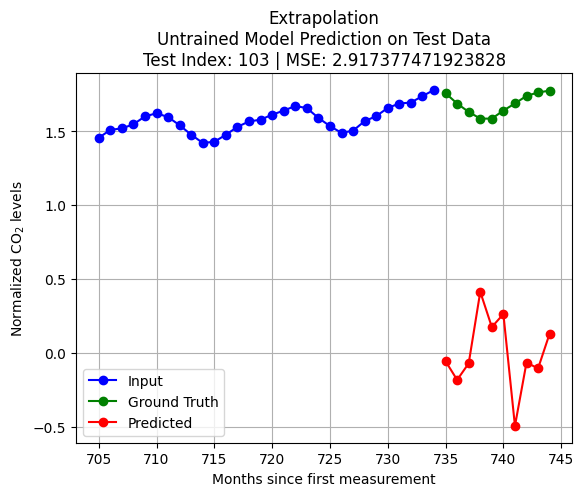

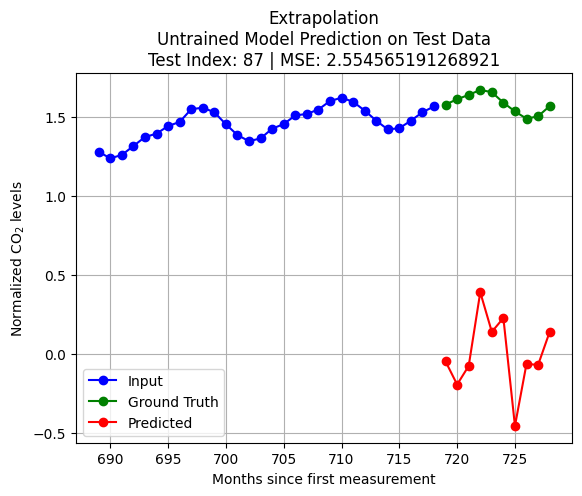

Epoch: 0 | Loss: 0.009825122898500228
Final Training Loss: 2.00798554984896e-05
Converged after 53 epochs


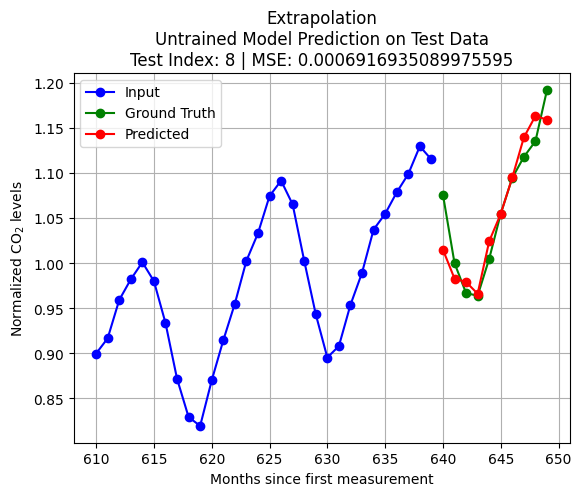

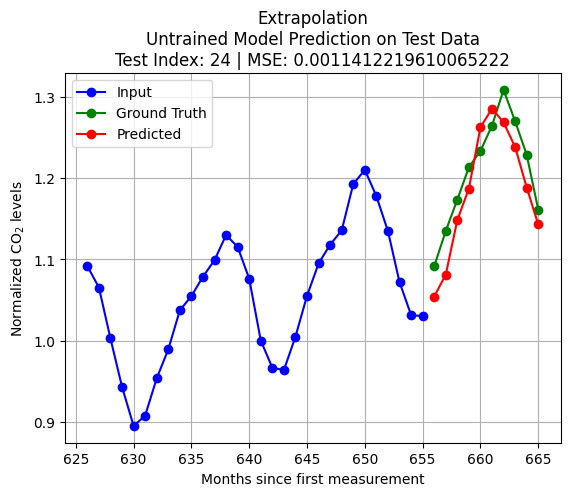

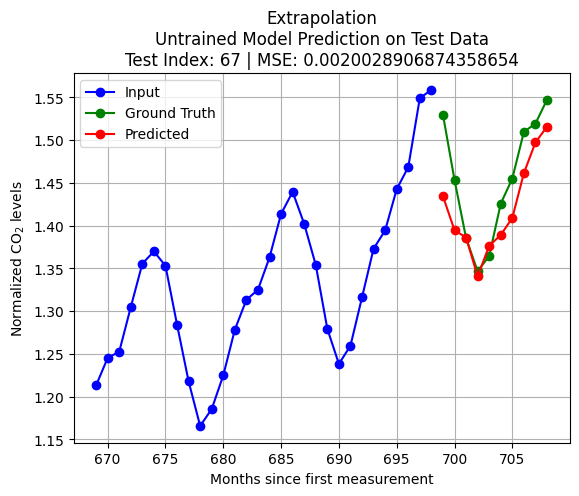

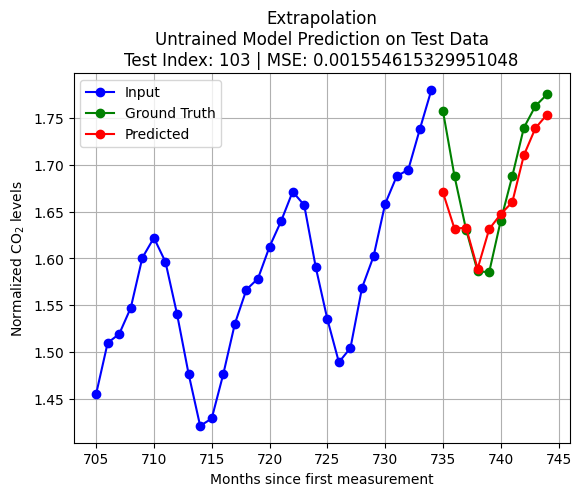

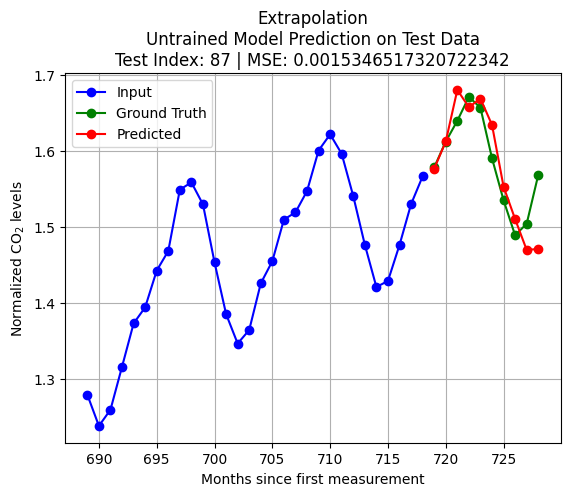

In [74]:
est = KTEstimator(scaled_D, 30, 10)

# Untrained Model Prediction
est.predict(model, 100, 5, cumulative = False)

#Trained Model Prediction
est.fit(model, 1e-8, 2000, 32, 0.01)
est.predict(model, 100, 5, cumulative  = False)

Cumulative Extrapolation (Given K, predict the next T cumulatively, keep using newer predicted values for further prediction)

In [126]:
K = 30
T = 1

hidden_size1 = 15
hidden_size2 = 8

model = MLP(input_dim = K, hidden_size1 = hidden_size1 , hidden_size2 = hidden_size2, output_dim = T)

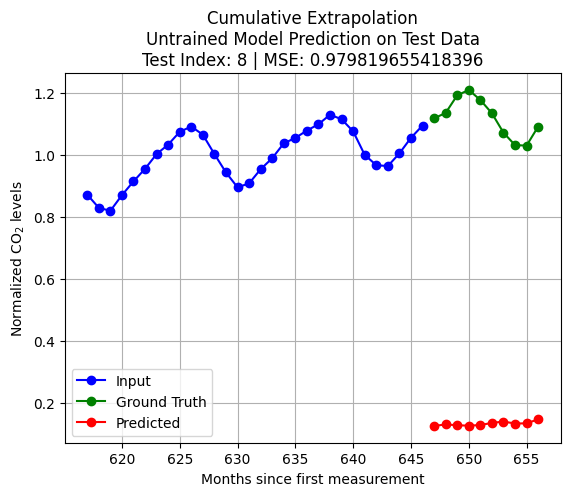

Epoch: 0 | Loss: 0.010330974746018354
Epoch: 100 | Loss: 1.0345684251081267e-05
Epoch: 200 | Loss: 8.453242370838907e-06
Epoch: 300 | Loss: 8.40567227047069e-06
Final Training Loss: 1.0954739919891168e-05
Converged after 325 epochs


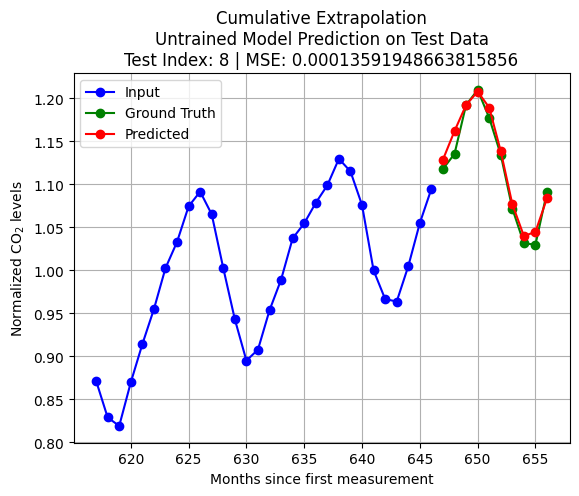

In [127]:
est2 = KTEstimator(scaled_D, K, T, 0.8)

# Untrained Model Prediction
est2.predict(model, 100, cumulative = True, pred_len = 10)

# Trained Model Prediction
est2.fit(model, 1e-8, 2000, 32, 0.01)
est2.predict(model, 100, cumulative = True, pred_len = 10)

MA (Moving Average) and ARMA (Auto Regressive Moving Average)

In [ ]:
class MA():
    def __init__(self, data:np.array = scaled_D, K = 3, T = 1, train_size:float = 0.80) -> None:
        self.K = K
        self.T = T
        
        # Creating Feature - Label Matrix        
        D = np.zeros(shape=(len(data)-(self.K+self.T)+1, self.K+self.T))
        for i in range(D.shape[0]):
            D[i] = np.concatenate([data[i:i+self.K,0], data[i+self.K:i+self.K+self.T,0]])
        
        # Test Train Split
        X_train, X_test, y_train, y_test = D[:int(len(D)*train_size),:self.K], D[int(len(D)*train_size):,:self.K], D[:int(len(D)*train_size),self.K:self.K+self.T], D[int(len(D)*train_size):,self.K:self.K+self.T]
        X_train = torch.tensor(X_train,dtype = torch.float32, device = device, requires_grad=False)
        y_train = torch.tensor(y_train,dtype = torch.float32, device = device, requires_grad=False)
        X_test = torch.tensor(X_test,dtype = torch.float32, device = device, requires_grad=False)
        y_test = torch.tensor(y_test,dtype = torch.float32, device = device, requires_grad=False)

        self.X_train, self.X_test, self.y_train, self.y_test = X_train, X_test, y_train, y_test

        return None
    
    def fit(self, model, convergence:float = 1e-8, num_epochs:int = 2000, batch_size:int = 32, lr:float = 0.001):

        # Training the model
        loss_fn = nn.MSELoss()
        opt = torch.optim.Adam(model.parameters(), lr = lr)
        print_every = 100

        dataset = TensorDataset(self.X_train, self.y_train)
        train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        losses = []

        for epoch in range(num_epochs):
            l = 0
            for data, target in train_dataloader:
                opt.zero_grad()
                y_pred = model(data)
                loss = loss_fn(y_pred, target.reshape(-1,self.T))
                l += loss.item()
                loss.backward()
                opt.step()
            
            losses.append(l/len(self.X_train))

            if epoch != 0 and abs(losses[-1] - losses[-2]) < convergence:
                print(f'Final Training Loss: {losses[-1]}')
                print(f'Converged after {epoch} epochs')
                break

            if epoch % print_every == 0:
                print(f"Epoch: {epoch} | Loss: {losses[-1]}")
        
        self.train_loss = losses
        return None
    
    def predict(self, model, seed:int = 42, num_test_cases:int = 5):
        
        if self.istrained == False:
            # Untrained Model Prediction
            np.random.seed(seed)
            loss_fn = nn.MSELoss()
            with torch.no_grad():
                test_indices = np.random.randint(0, len(self.X_test), size = num_test_cases)
                for i in test_indices:
                    y = model(self.X_test[i])
                    loss = loss_fn(y, self.y_test[i])
                    plt.title(f'Extrapolation\nUntrained Model Prediction on Test Data\nTest Index: {i} | MSE: {loss}')
                    plt.plot(np.arange(i+len(self.X_train),i+len(self.X_train)+self.K,1), self.X_test[i], 'bo-')
                    plt.plot(np.arange(i+len(self.X_train)+self.K,i+len(self.X_train)+self.K+self.T,1), self.y_test[i].detach().numpy(), 'go-')
                    plt.plot(np.arange(i+len(self.X_train)+self.K,i+len(self.X_train)+self.K+self.T,1), y.detach().numpy(), 'ro-')
                    plt.legend(['Input','Ground Truth','Predicted'])
                    plt.xlabel('Months since first measurement')
                    plt.ylabel(r'Normalized CO$_2$ levels')
                    plt.grid()
                    plt.show()
        else:
            # Trained Model Prediction
            np.random.seed(seed)
            with torch.no_grad():
                test_indices = np.random.randint(0, len(self.X_test), size = num_test_cases)
                for i in test_indices:
                    y = model(self.X_test[i])
                    loss = loss_fn(y, self.y_test[i])
                    plt.title(f'Extrapolation\nTrained Model Prediction on Test Data\nTest Index: {i} | MSE: {loss}')
                    plt.plot(np.arange(i+len(self.X_train),i+len(self.X_train)+self.K,1), self.X_test[i], 'bo-')
                    plt.plot(np.arange(i+len(self.X_train)+self.K,i+len(self.X_train)+self.K+self.T,1), self.y_test[i].detach().numpy(), 'go-')
                    plt.plot(np.arange(i+len(self.X_train)+self.K,i+len(self.X_train)+self.K+self.T,1), y.detach().numpy(), 'ro-')
                    plt.legend(['Input','Ground Truth','Predicted'])
                    plt.xlabel('Months since first measurement')
                    plt.ylabel(r'Normalized CO$_2$ levels')
                    plt.grid()
                    plt.show()
            
        return None